Source: https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html#Max-Cut-problem

# Traveling Salesman Problem (TSP) – Mathematical Formulation

The **Traveling Salesman Problem (TSP)** is a well-known problem in computer science and mathematics. It asks:

> Given a list of cities and the distances between each pair, what is the shortest possible route that visits each city exactly once and returns to the starting city?

This is a classic **NP-hard** problem, meaning that no algorithm is known to solve it efficiently for all possible inputs. Despite its simplicity, TSP has drawn attention for over two centuries due to its difficulty and broad applicability.

**Real-world applications** include:
- Logistics and route planning
- Circuit design
- Genomics and biology
- Marketing and operations research

---

**Graph Representation**

TSP can be represented as a graph:

- Each **city** is a **node** (or vertex).
- Each **path** between cities is an **edge** with an associated **distance** or **cost**.

The goal is to find the shortest **Hamiltonian cycle** — a closed path that visits every node exactly once and returns to the starting node.

---

**Mathematical Formulation**

Let $N$ be the number of cities. Define binary variables:

$$
x_{i,t} =
\begin{cases}
1 & \text{if city } i \text{ is visited at time } t \\
0 & \text{otherwise}
\end{cases}
$$

These variables must satisfy two constraints:

1. **Each city is visited exactly once:**

$$
\sum_{t=0}^{N-1} x_{i,t} = 1 \quad \text{for all } i = 0, 1, ..., N-1
$$

2. **Each time step must have exactly one city:**

$$
\sum_{i=0}^{N-1} x_{i,t} = 1 \quad \text{for all } t = 0, 1, ..., N-1
$$

---

**Objective Function**

Let $D_{ij}$ be the distance between cities  $i$ and $j$. The total tour cost is the sum of the distances between consecutive cities in the tour:

$$
\text{Cost} = \sum_{i,j,t} D_{ij} \cdot x_{i,t} \cdot x_{j,(t+1) \mod N}
$$

Our objective is to **minimize** this cost.

---

**Mapping to the Ising Model (for quantum or QUBO solvers)**

We can convert the constrained problem to an unconstrained form by introducing a **penalized objective function**:

$$
H = A \cdot H_{\text{constraints}} + B \cdot H_{\text{distance}}
$$

Where:
- $H_{\text{constraints}}$ enforces the valid tour conditions.
- $H_{\text{distance}}$ encodes the cost to be minimized.
- $A \gg B$ ensures constraints are strictly enforced.

This is the form used when solving TSP on quantum devices or with optimization packages that accept Ising or QUBO input.

## Installing the Required packages

In [1]:
!pip install qiskit==1.0.1
!pip install qiskit-optimization==0.6.1
!pip install qiskit-algorithms==0.3.0
# !pip install numpy==1.23.5 --force-reinstall

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

**Graph Visualization Function**

This function is used to visually represent the cities (nodes) and the distances (edges) in the Traveling Salesman Problem.

- The graph is drawn using **NetworkX** and **Matplotlib**.
- Each node represents a city, and each edge represents the path (or distance) between two cities.
- The `colors` argument allows you to specify custom colors for nodes (useful when highlighting visited cities or paths).
- `pos` is the position layout dictionary that determines where each node appears on the plot.
- The weights of the edges (distances) are also shown as labels on the graph for clarity.

This visual aid helps to better understand the structure of the problem and can assist in verifying the results of the algorithm.

In [3]:
# draw graph function to display the graph

# def draw_graph(G, colors, pos):
#     default_axes = plt.axes(frameon=True)
#     nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
#     edge_labels = nx.get_edge_attributes(G, "weight")
#     nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

from rustworkx.visualization import mpl_draw
import rustworkx as rx

def draw_rx_graph(nx_graph, node_color="#1192E8"):
    """
    Converts a NetworkX graph to a rustworkx graph and visualizes it.

    Parameters:
    - nx_graph: A NetworkX graph object (e.g., tsp.graph)
    - node_color: Color of the nodes in hex format or color name
    """
    # Create a rustworkx graph
    G_rx = rx.PyGraph()
    G_rx.add_nodes_from(list(nx_graph.nodes))

    # Extract edges with weights
    edges = [(u, v, d.get("weight", 1.0)) for u, v, d in nx_graph.edges(data=True)]
    G_rx.add_edges_from(edges)

    # Use shell layout or any other layout rustworkx supports
    mpl_draw(G_rx, pos=rx.shell_layout(G_rx), with_labels=True, edge_labels=str, node_color=node_color)


**Generating a Random TSP Instance**

This code block creates a simple Traveling Salesman Problem instance with 3 nodes (cities).

- `n` sets the number of cities.
- `num_qubits = n^2` calculates the number of qubits required for mapping this TSP to an Ising model, where each node has a time slot.
- `Tsp.create_random_instance(n, seed=123)` generates a random, fully connected graph of 3 nodes using a fixed seed for reproducibility.
- The graph's adjacency matrix (`adj_matrix`) represents the distances between all pairs of cities.
- `colors` assigns a default red color (`"r"`) to all the cities.
- `pos` stores the positions of each node to ensure consistent and meaningful plotting.
- Finally, the `draw_graph()` function is called to visualize the generated TSP graph with edge weights representing the distances.

This setup allows us to simulate and solve small TSP instances visually and computationally.


distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


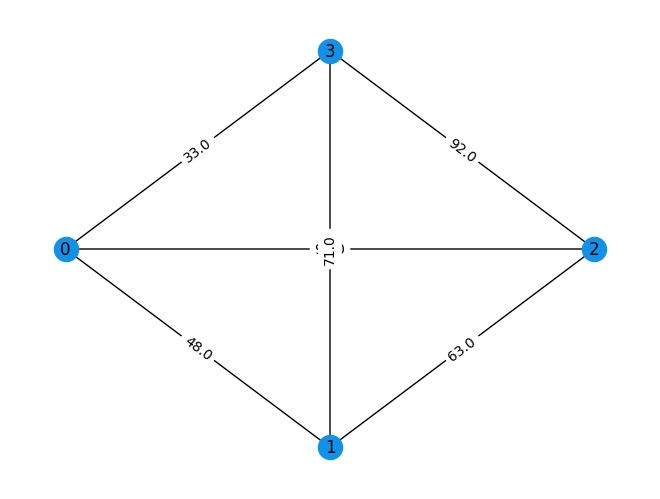

In [9]:
# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

draw_rx_graph(tsp.graph)  # no need to manually pass colors or pos

**Brute Force Solution to the Traveling Salesman Problem**

This section implements and visualizes a brute-force approach to solving the Traveling Salesman Problem (TSP) for a small number of nodes.

- `brute_force_tsp(w, N)` takes the adjacency matrix `w` and number of nodes `N` and tries **all possible permutations** of cities (excluding the start node 0) to find the optimal route.
- For each permutation:
  - It calculates the **total distance** traveled if the salesman follows that path and returns to the starting node.
  - If this distance is less than the previously best-known distance, it updates the best solution and prints it.
- Finally, it returns the best distance and corresponding order of nodes visited.

This method is only feasible for very small graphs (like 3-5 nodes) because its time complexity is $O(n!)$ due to checking every possible permutation.

The `draw_tsp_solution()` function then:
- **Creates a directed version** of the TSP graph (`G2`) to reflect the order of the path found.
- Adds directed edges according to the optimal order.
- Uses NetworkX and Matplotlib to **visualize the solution path**, highlighting the route and distances.

This visualization provides an intuitive understanding of the brute-force solution's output.


order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


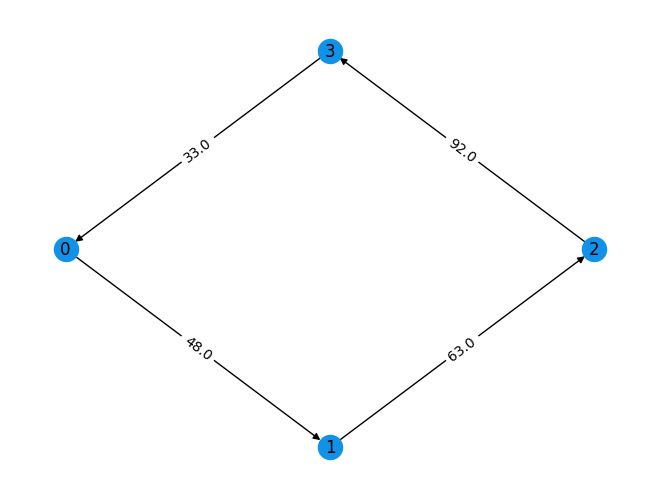

In [10]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_rx_tsp_solution(nx_graph, order, node_color="#1192E8"):
    """
    Draws the TSP solution path using Rustworkx.

    Parameters:
    - nx_graph: the original NetworkX graph (e.g., tsp.graph)
    - order: list or tuple representing the path (e.g., from brute force)
    - node_color: Hex color for nodes (default blue)
    """
    G_rx = rx.PyDiGraph()
    G_rx.add_nodes_from(list(nx_graph.nodes))

    # Add the ordered edges to the DiGraph with weights
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        u = order[i]
        v = order[j]
        weight = nx_graph[u][v].get("weight", 1.0)
        G_rx.add_edge(u, v, weight)

    # Draw with node and edge labels
    mpl_draw(G_rx, pos=rx.shell_layout(G_rx), with_labels=True, edge_labels=str, node_color=node_color)


draw_rx_tsp_solution(tsp.graph, best_order)

**Formulating the TSP as a Quadratic Program (QP)**

This section translates the Traveling Salesman Problem into a **Quadratic Program (QP)** formulation using Qiskit's optimization tools.

- The method `tsp.to_quadratic_program()` performs the mathematical **mapping from the TSP to a QP**.
- The resulting `qp` object contains:
  - **Binary variables** representing whether a city is visited at a specific position.
  - **Objective function** that encodes the total distance traveled.
  - **Constraints** that enforce a valid Hamiltonian cycle:
    - Each city is visited exactly once.
    - Each position in the tour is occupied by exactly one city.

This QP formulation is a necessary step in order to later **map the problem to an Ising Hamiltonian**, which can be solved by quantum or quantum-inspired algorithms.

The command `qp.prettyprint()` displays the structure of the QP clearly, showing the objective and constraints in human-readable form.

In [11]:
# Mapping to Ising problem
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

**Mapping the Quadratic Program to an Ising Hamiltonian**

This section continues the pipeline by converting the **Quadratic Program (QP)** into an **Ising Hamiltonian**, which is a key representation for solving the problem using quantum algorithms.

- `QuadraticProgramToQubo()` converts the QP to a **Quadratic Unconstrained Binary Optimization (QUBO)** form. This is required before mapping to the Ising model.
- `qubo.to_ising()` then maps the QUBO to a corresponding **Ising Hamiltonian**, which consists of:
  - A **Hamiltonian operator (`qubitOp`)** that describes the energy landscape of the problem.
  - An **offset** value that accounts for constant shifts in the energy.

The final Ising Hamiltonian represents the TSP in a form that can be solved by quantum algorithms such as the **Quantum Approximate Optimization Algorithm (QAOA)**. The goal becomes finding the lowest-energy (ground state) configuration, which corresponds to the optimal tour.

In [12]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 51756.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIII

**Solving the TSP Using a Classical Exact Eigensolver**

At this stage, we use a **classical solver** to find the minimum-energy solution to the Ising Hamiltonian derived from the QUBO.

- `MinimumEigenOptimizer(NumPyMinimumEigensolver())` wraps the Ising model in an optimizer that uses **NumPy's exact eigensolver** to compute the solution.
- This classical eigensolver finds the **ground state** (lowest energy configuration), which corresponds to the shortest tour in the TSP instance.
- The `.solve(qubo)` call applies the solver to the Ising representation of the problem, and the result includes both the optimal route and its cost.
- `result.prettyprint()` displays the formatted solution for easier interpretation.

This step allows us to verify correctness and visualize the optimal TSP tour using classical computation before moving on to quantum techniques.

In [13]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 236.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=0.0, x_0_3=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0
status: SUCCESS


**Verification of the TSP Solution Using the Hamiltonian**

In this part of the code, we check that the solution obtained from the Ising model corresponds to the correct **TSP objective**:

1. **Calculating the Eigenvalue**:
   - We first use the `NumPyMinimumEigensolver` to compute the minimum eigenvalue of the Ising Hamiltonian using the `compute_minimum_eigenvalue(qubitOp)` method.
   - This eigenvalue represents the **energy** of the system in its ground state, which corresponds to the optimal solution of the TSP.

2. **Energy and Objective**:
   - The `result.eigenvalue.real` gives the energy of the system, while adding the `offset` gives us the **TSP objective**, representing the total distance of the optimal tour.

3. **Sampling the Most Likely State**:
   - The `sample_most_likely(result.eigenstate)` method extracts the most likely state (bitstring) from the quantum solution.

4. **Feasibility Check**:
   - We check whether the sampled state is feasible with respect to the constraints of the problem using `qubo.is_feasible(x)`.

5. **Interpreting the Solution**:
   - The bitstring is then interpreted using `tsp.interpret(x)` to obtain the actual node visit order of the TSP solution.

6. **Displaying the Solution**:
   - Finally, the optimal solution path is displayed with `draw_tsp_solution(tsp.graph, z, colors, pos)`.

This code verifies the correctness of the solution by comparing the computed energy with the TSP objective and ensures the feasibility and validity of the resulting solution.

energy: -51520.0
tsp objective: 236.0
feasible: True
solution: [1, 2, 3, 0]
solution objective: 236.0


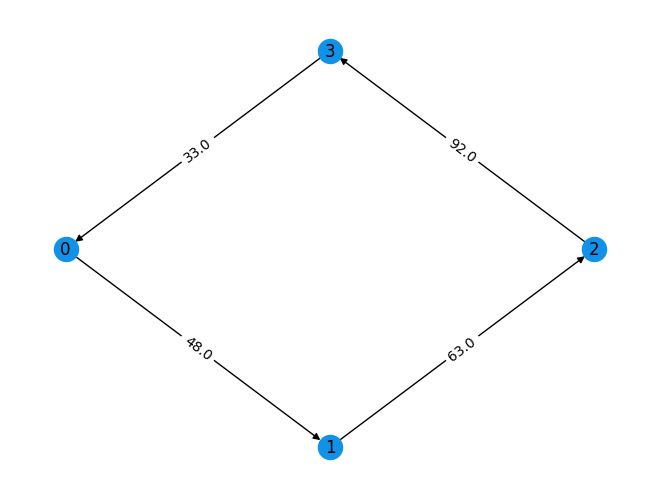

In [14]:
# Check that it gives the right cost

# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)
energy_exact = result.eigenvalue.real

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_rx_tsp_solution(tsp.graph, z)

# Run On a Quantum Computer

**Solving the TSP with Variational Quantum Eigensolver (VQE)**

In this section, we use a **Variational Quantum Eigensolver (VQE)** algorithm to solve the TSP. VQE is a hybrid quantum-classical algorithm that can find the minimum eigenvalue of a Hamiltonian, which corresponds to the optimal TSP solution.

1. **Setting Random Seed**:
   - We set the `algorithm_globals.random_seed` for reproducibility, ensuring that the results are consistent across runs.
   
2. **Optimizer and Ansatz**:
   - The **Simultaneous Perturbation Stochastic Approximation (SPSA)** optimizer is used for VQE, with a maximum of 300 iterations (`maxiter=300`). This optimizer helps in minimizing the energy (Hamiltonian) through a series of iterations.
   - The ansatz, a parameterized quantum circuit, is chosen as a **TwoLocal** circuit with the `ry` rotation and `cz` entanglement gates. This is repeated 5 times (`reps=5`), with a linear entanglement structure.

3. **VQE Setup**:
   - We initialize the VQE with the chosen optimizer (`SPSA`) and ansatz (`ry`). The quantum state is prepared by applying the parameterized ansatz, and the energy is minimized iteratively.

4. **Compute Minimum Eigenvalue**:
   - The `compute_minimum_eigenvalue(qubitOp)` method computes the eigenvalue of the Hamiltonian, which corresponds to the optimal TSP solution.
   - The energy (the minimum eigenvalue) is printed out, and the optimization time (`result.optimizer_time`) is also displayed.

5. **Sampling and Interpreting the Solution**:
   - The most likely state (`result.eigenstate`) is sampled using `tsp.sample_most_likely()`, and it is checked for feasibility using `qubo.is_feasible(x)`.
   - The solution is interpreted using `tsp.interpret(x)` to retrieve the node visit order for the TSP path.

6. **Display Solution**:
   - The optimal path is visualized using `draw_tsp_solution(tsp.graph, z, colors, pos)`.

This approach leverages quantum computing to find the optimal TSP solution using the VQE algorithm, offering a glimpse of how quantum algorithms can potentially solve combinatorial optimization problems.

In [15]:
algorithm_globals.random_seed = 123
seed = 10598

**Comparing Solutions Using Relative Error**

To understand how close each algorithm comes to the best possible solution, we calculate the **relative error**:

$ \text{error} = \frac{\text{energy} - E_{\min}}{|\!E_{\min}|} $

This tells us how far each energy value is from the true minimum energy (usually from brute force or exact classical methods).

- A relative error of **0** means a perfect match.
- Larger values mean the algorithm found a less optimal solution.

The bar chart shows this comparison visually, highlighting which method performs best.

In [17]:
import matplotlib.pyplot as plt

# Define your optimizer and ansatz
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

# Setup VQE with callback
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# Run VQE and get result
result = vqe.compute_minimum_eigenvalue(qubitOp)
energy_vqe = result.eigenvalue.real

# from brute force
energy_brute = best_distance

# add the offset
energy_vqe += offset
energy_brute += offset

# Example energies: replace with your actual results
energies = [energy_vqe, energy_brute, energy_exact]  # Replace these
labels = ["VQE", "Brute Force", "Exact"]

# Set the minimum energy (typically the exact one)
E_min = min(energies)

# Compute relative errors
errors = [(E - E_min) / abs(E_min) for E in energies]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, errors, color=["#FF6F61", "#6B5B95", "#88B04B"])
plt.title("Relative Error Compared to Minimum Energy", fontsize=14)
plt.ylabel("Relative Error")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.3e}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

energy: -7326.02469952184
time: 21.967929124832153
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


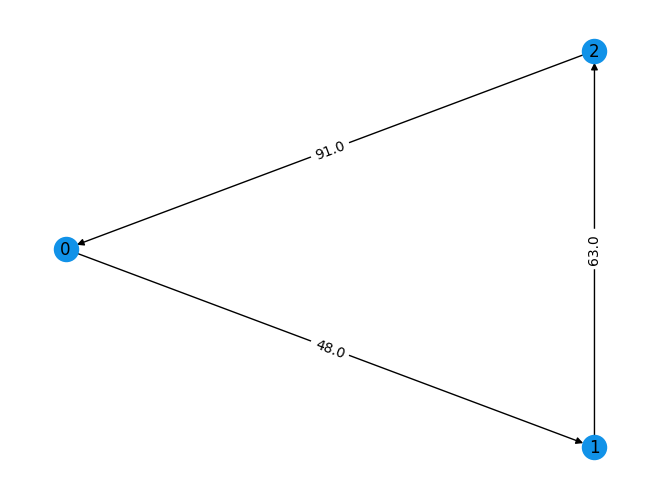

In [15]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_rx_tsp_solution(tsp.graph, z)

**Using SamplingVQE to Solve the TSP with Minimum Eigen Optimizer**

In this section, we leverage the **SamplingVQE** algorithm along with a **Minimum Eigen Optimizer** to solve the TSP problem. The approach combines quantum computation with classical optimization techniques to efficiently minimize the TSP objective.

1. **Random Seed Setup**:
   - We set the random seed (`algorithm_globals.random_seed = 123`) for reproducibility of results. This ensures the algorithm produces consistent outputs across different runs.

2. **SamplingVQE and Minimum Eigen Optimizer**:
   - The **SamplingVQE** algorithm, which was previously configured with an ansatz and optimizer, is now wrapped inside a **MinimumEigenOptimizer**. This optimizer utilizes the quantum VQE results to minimize the Hamiltonian and find the optimal TSP solution.

3. **Solving the Quadratic Program (QP)**:
   - The `vqe_optimizer.solve(qp)` method is used to solve the quadratic program (QP) formulated earlier in the process. The solver minimizes the energy function of the problem, helping to find the best route for the salesman.

4. **Display Results**:
   - The result of the optimization is displayed using `result.prettyprint()`, showing the optimization process and the minimum energy found.
   
5. **Solution Interpretation**:
   - The quantum solution is interpreted using `tsp.interpret(x)`, which converts the output into a feasible TSP solution. The optimal node visit order is printed, along with the TSP value (objective function value), calculated using `tsp.tsp_value(z, adj_matrix)`.

6. **Visualization**:
   - The TSP solution is visualized on the graph using the `draw_tsp_solution(tsp.graph, z, colors, pos)` function, displaying the optimal path based on the quantum solution.

By combining classical optimization with quantum algorithms, this approach showcases how quantum computing can be applied to combinatorial problems like the Traveling Salesman Problem (TSP).

In [16]:
algorithm_globals.random_seed = 123
seed = 10598

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0
status: SUCCESS
solution: [1, 2, 0]
solution objective: 202.0


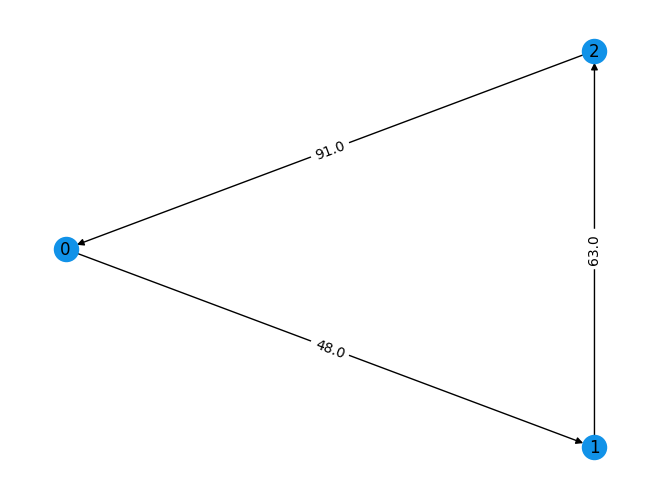

In [17]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_rx_tsp_solution(tsp.graph, z)